# Convolutional Neural Network (CNN)

A Convolutional Neural Network (CNN) is a type of deep learning model primarily used in computer vision tasks, particularly for image recognition, object detection, and image classification.

What makes CNNs powerful for image-related tasks is their ability to automatically and adaptively learn spatial hierarchies of features from the input data. They consist of multiple layers, typically including convolutional layers, pooling layers, and fully connected layers.

In this part we will implement our first convolutional neural network (CNN) that can do image classification based on the famous CIFAR-10 dataset.

We will learn:
- Architecture of CNNs
- Convolutional Filter
- Max Pooling
- Determine the correct layer size
- Implement the CNN architecture in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

#### Device configuration

In [2]:
# devive configuration

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Hyper-parameters

In [3]:
# hyper parameters

num_epochs = 4
batch_size = 4
learning_rate = 0.001

#### Load the CIFAR-10 dataset

In [4]:
# dataset has PILImage images of range [0, 1]   
# we transform them to Tensors of normalized range [-1, 1]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))  # 3 channels for RGB
])

Explicando o código acima:

1. `transforms.Compose([...])`: Isso cria uma sequência de transformações que serão aplicadas às imagens. No caso específico, estamos definindo duas transformações a serem aplicadas sequencialmente.

2. `transforms.ToTensor()`: Esta transformação converte a imagem PIL (Pillow) para um tensor do PyTorch. As imagens originalmente estão no formato PIL (PILImage) e esta etapa as converte para tensores, que são a estrutura de dados usada pelo PyTorch para manipular dados.

3. `transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`: Essa transformação normaliza os tensores de imagem. Aqui, há dois conjuntos de três valores cada um. O primeiro conjunto (0.5, 0.5, 0.5) representa a média para cada canal de cor (vermelho, verde, azul, respectivamente), e o segundo conjunto (0.5, 0.5, 0.5) representa o desvio padrão para cada canal de cor. A fórmula para normalização é: `input[channel] = (input[channel] - mean[channel]) / std[channel]`. Isso coloca os valores dos pixels no intervalo de [-1, 1], o que é comum em redes neurais, ajudando no treinamento.

Essas transformações são frequentemente aplicadas a conjuntos de dados de imagens antes de serem alimentadas em uma rede neural convolucional (CNN) no PyTorch. Isso garante que os dados estejam em um formato adequado e preparado para o treinamento da rede.

In [5]:
# load dataset. CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class


train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)  

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # shuffle for randomization

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # shuffle for randomization

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  # 10 classes

100%|██████████| 170498071/170498071 [01:20<00:00, 2118753.33it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explicando o código acima:

Esse código é responsável por carregar o conjunto de dados CIFAR-10, dividindo-o em conjuntos de treinamento e teste, e preparando os dados para serem usados em lotes durante o treinamento e teste de uma CNN no PyTorch. Aqui está o que cada linha faz:

1. `train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)`: Esta linha carrega o conjunto de dados CIFAR-10 para treinamento. Se o conjunto de dados não estiver presente no diretório especificado (./data), ele será baixado. Ele aplica as transformações definidas anteriormente (no caso, as transformações para conversão para tensores e normalização).

2. `test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)`: Similar ao anterior, mas este carrega o conjunto de dados CIFAR-10 para teste. Ele também aplica as mesmas transformações.

3. `train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)`: Isso cria um DataLoader para o conjunto de treinamento. O DataLoader é útil para iterar pelos dados em lotes durante o treinamento da CNN. Ele divide os dados em lotes de tamanho `batch_size` e, ao definir `shuffle=True`, embaralha os dados a cada época para garantir uma melhor aleatoriedade durante o treinamento.

4. `test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)`: Similar ao `train_loader`, mas este é para o conjunto de teste. Ele não precisa embaralhar os dados, pois o conjunto de teste é usado para avaliação, não para treinamento.

5. `classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')`: Esta linha define uma tupla com os nomes das classes presentes no conjunto de dados CIFAR-10. Cada classe corresponde a uma categoria específica de imagens que estão no conjunto de dados.

Esse código é um passo importante na preparação de conjuntos de dados para treinar e testar uma CNN usando o PyTorch, e esses conjuntos de dados agora estão prontos para serem usados para treinamento e avaliação de modelos de CNN.

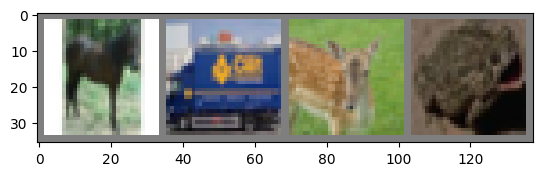

In [8]:
# show some images

def imshow(img):  
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()  # convert to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # transpose to change axis order from (channels, height, width) to (height, width, channels)
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)


# show images
imshow(torchvision.utils.make_grid(images))

Explicando o código acima:

Esse bloco de código tem o objetivo de exibir algumas imagens do conjunto de dados CIFAR-10 antes de treinar o modelo. Vamos explicar o que cada parte do código faz:

1. `def imshow(img):`: Isso define uma função chamada `imshow` que será usada para exibir imagens.

2. `img = img / 2 + 0.5`: Essa linha reverte a normalização aplicada anteriormente. Ela desfaz o processo de normalização para que as imagens possam ser visualizadas corretamente.

3. `npimg = img.numpy()`: Converte a imagem de um tensor do PyTorch para um array numpy. Isso é necessário para que a imagem possa ser mostrada com a biblioteca matplotlib.

4. `plt.imshow(np.transpose(npimg, (1, 2, 0)))`: `plt.imshow` é usado para exibir a imagem. `np.transpose` é usado para alterar a ordem dos eixos da imagem de (canais, altura, largura) para (altura, largura, canais), que é o formato esperado pela função `imshow`.

5. `plt.show()`: Mostra a imagem.

6. `dataiter = iter(train_loader)`: Cria um iterador para percorrer os dados de treinamento em lotes.

7. `images, labels = next(dataiter)`: Obtém um lote de imagens e seus rótulos do iterador.

8. `imshow(torchvision.utils.make_grid(images))`: Chama a função `imshow` para mostrar um grid com várias imagens. `torchvision.utils.make_grid` cria um grid a partir do conjunto de imagens passado como argumento.

Basicamente, esse bloco de código exibe uma grade de imagens do conjunto de dados de treinamento CIFAR-10, permitindo uma visualização rápida das imagens que serão usadas para treinar o modelo de CNN.

#### Implement the CNN architecture

In [9]:
# implement CNN class

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 6, 5)  # 3 input channels for RGB
        self.pool = nn.MaxPool2d(2, 2)  # max pooling over a (2, 2) window
        self.conv2 = nn.Conv2d(6, 16, 5)  # 6 input channels for 6 output channels from previous layer
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5x5 image dimension after 2 pooling layers
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 1st convolution layer, then ReLU activation, then pooling
        x = self.pool(F.relu(self.conv2(x)))  # 2nd convolution layer, then ReLU activation, then pooling
        x = x.view(-1, 16 * 5 * 5)  # reshape to 1D tensor
        x = F.relu(self.fc1(x))  # 1st fully connected layer, then ReLU activation
        x = F.relu(self.fc2(x))  # 2nd fully connected layer, then ReLU activation
        x = self.fc3(x)  # 3rd fully connected layer
        return x
    
model = ConvNet().to(device)

Explicando o código acima:

Esse é um código que define uma classe `ConvNet`, que representa a arquitetura de uma Convolutional Neural Network (CNN) no PyTorch. Aqui está o que cada parte do código faz:

1. `class ConvNet(nn.Module):`: Define a classe `ConvNet` que herda da classe `nn.Module`, uma classe base para todos os módulos de redes neurais no PyTorch.

2. `def __init__(self):`: O método `__init__` é o inicializador da classe `ConvNet`. Aqui são definidas as camadas da rede neural.

   - `self.conv1 = nn.Conv2d(3, 6, 5)`: Primeira camada convolucional com 3 canais de entrada (para imagens RGB), 6 canais de saída e um kernel de convolução 5x5.
   
   - `self.pool = nn.MaxPool2d(2, 2)`: Camada de max pooling com uma janela de pooling de (2, 2).
   
   - `self.conv2 = nn.Conv2d(6, 16, 5)`: Segunda camada convolucional com 6 canais de entrada (do resultado da camada anterior) e 16 canais de saída, também com um kernel de convolução 5x5.
   
   - `self.fc1 = nn.Linear(16 * 5 * 5, 120)`: Camada totalmente conectada com 16x5x5 neurônios de entrada (resultado das camadas convolucionais) e 120 neurônios de saída.
   
   - `self.fc2 = nn.Linear(120, 84)`: Outra camada totalmente conectada com 120 neurônios de entrada e 84 neurônios de saída.
   
   - `self.fc3 = nn.Linear(84, 10)`: Última camada totalmente conectada com 84 neurônios de entrada (resultado da camada anterior) e 10 neurônios de saída, correspondendo às 10 classes do conjunto de dados CIFAR-10.
   
3. `def forward(self, x):`: Define o método `forward` que descreve como os dados são passados pela rede.

   - `x = self.pool(F.relu(self.conv1(x)))`: Passa os dados de entrada `x` pela primeira camada convolucional, aplica a função de ativação ReLU e em seguida aplica max pooling.
   
   - `x = self.pool(F.relu(self.conv2(x)))`: Similar ao passo anterior, mas usando a segunda camada convolucional.
   
   - `x = x.view(-1, 16 * 5 * 5)`: Redimensiona os dados para um vetor unidimensional.
   
   - `x = F.relu(self.fc1(x))`: Passa os dados pela primeira camada totalmente conectada e aplica a função de ativação ReLU.
   
   - `x = F.relu(self.fc2(x))`: Similar ao passo anterior, mas usando a segunda camada totalmente conectada.
   
   - `x = self.fc3(x)`: Última camada totalmente conectada, que retorna as previsões para cada classe.

4. `model = ConvNet().to(device)`: Cria uma instância da classe `ConvNet` e a move para o dispositivo de computação especificado (por exemplo, CPU ou GPU). Isso cria o modelo da CNN que será treinado usando os dados CIFAR-10 que você carregou anteriormente.

Este código define a arquitetura básica de uma CNN no PyTorch, com camadas convolucionais, camadas de pooling e camadas totalmente conectadas.

#### Loss and optimizer

In [10]:
# loss and optimizer

criterion = nn.CrossEntropyLoss()  # loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # stochastic gradient descent

Explicando o código acima:

Esse trecho de código define a função de perda (loss function) e o otimizador para o treinamento da CNN. Aqui está o que cada linha faz:

1. `criterion = nn.CrossEntropyLoss()`: Isso define a função de perda que será usada para calcular o quão bem o modelo está performando durante o treinamento. No caso, está sendo utilizada a função de perda de entropia cruzada (Cross Entropy Loss), comumente usada em problemas de classificação multiclasse como o CIFAR-10.

2. `optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)`: Isso define o otimizador que será usado para atualizar os pesos da rede durante o treinamento. Neste caso, está sendo utilizado o otimizador SGD (Stochastic Gradient Descent) com os parâmetros do modelo (`model.parameters()`). O parâmetro `lr=learning_rate` define a taxa de aprendizado (learning rate), que controla o tamanho dos passos dados durante a atualização dos pesos.

Juntos, esses dois elementos são essenciais para treinar uma rede neural. A função de perda é usada para calcular o quão distantes as previsões do modelo estão das classes reais, enquanto o otimizador é responsável por ajustar os pesos da rede de acordo com essa informação de erro, na direção que melhore o desempenho do modelo.

#### Train the model

In [11]:
# training loop

n_total_steps = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5x5 kernel
        images = images.to(device)
        labels = labels.to(device)
        
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)  # calculate loss
        
        # backward pass
        optimizer.zero_grad()  # zero out gradients
        loss.backward()  # backpropagation
        optimizer.step()  # update weights
        
        if (i+1) % 2000 == 0:
            print(f'epoch {epoch+1} / {num_epochs}, step {i+1} / {n_total_steps}, loss = {loss.item():.4f}')

print('Finished training')

epoch 1 / 4, step 2000 / 12500, loss = 2.2734
epoch 1 / 4, step 4000 / 12500, loss = 2.3290
epoch 1 / 4, step 6000 / 12500, loss = 2.2854
epoch 1 / 4, step 8000 / 12500, loss = 2.2703
epoch 1 / 4, step 10000 / 12500, loss = 2.1871
epoch 1 / 4, step 12000 / 12500, loss = 2.3377
epoch 2 / 4, step 2000 / 12500, loss = 2.1094
epoch 2 / 4, step 4000 / 12500, loss = 1.8312
epoch 2 / 4, step 6000 / 12500, loss = 2.2434
epoch 2 / 4, step 8000 / 12500, loss = 1.7664
epoch 2 / 4, step 10000 / 12500, loss = 1.1636
epoch 2 / 4, step 12000 / 12500, loss = 1.2319
epoch 3 / 4, step 2000 / 12500, loss = 1.5587
epoch 3 / 4, step 4000 / 12500, loss = 1.3368
epoch 3 / 4, step 6000 / 12500, loss = 2.3199
epoch 3 / 4, step 8000 / 12500, loss = 1.4576
epoch 3 / 4, step 10000 / 12500, loss = 1.9081
epoch 3 / 4, step 12000 / 12500, loss = 2.3345
epoch 4 / 4, step 2000 / 12500, loss = 1.2938
epoch 4 / 4, step 4000 / 12500, loss = 1.1430
epoch 4 / 4, step 6000 / 12500, loss = 1.5750
epoch 4 / 4, step 8000 / 125

Explicando o código acima:

Este código representa um loop de treinamento para a rede neural. Aqui está o que cada parte faz:

1. `n_total_steps = len(train_loader)`: Calcula o número total de lotes (batches) no conjunto de treinamento. Isso será usado para determinar o progresso durante o treinamento.

2. O loop externo `for epoch in range(num_epochs):` é responsável por iterar sobre o número de épocas definidas para o treinamento da rede. Cada época significa passar por todo o conjunto de dados de treinamento uma vez.

3. O loop interno `for i, (images, labels) in enumerate(train_loader):` percorre cada lote no conjunto de dados de treinamento.

   - `images = images.to(device)` e `labels = labels.to(device)`: Move os dados de entrada e rótulos para o dispositivo de computação (CPU ou GPU) especificado.
   
   - `outputs = model(images)`: Realiza a passagem direta (forward pass) dos dados pela rede neural para obter as previsões.
   
   - `loss = criterion(outputs, labels)`: Calcula a perda (loss) comparando as previsões da rede (`outputs`) com os rótulos reais (`labels`), usando a função de perda (no caso, a Cross Entropy Loss).
   
   - `optimizer.zero_grad()`: Zera os gradientes existentes antes de fazer a retropropagação (backpropagation) para evitar acumulação de gradientes de iterações anteriores.
   
   - `loss.backward()`: Realiza a retropropagação para calcular os gradientes de cada peso em relação à perda.
   
   - `optimizer.step()`: Atualiza os pesos da rede neural com base nos gradientes calculados durante a retropropagação, utilizando o otimizador SGD.
   
   - `if (i+1) % 2000 == 0:`: A cada 2000 passos, imprime informações sobre a época atual, o número do passo, o número total de passos por época e a perda atual.
   
4. Depois que todas as épocas e passos foram percorridos, a mensagem 'Finished training' é exibida para indicar que o treinamento foi concluído.

Esse é o processo de treinamento de uma rede neural, onde os pesos são ajustados iterativamente com o objetivo de minimizar a perda e melhorar o desempenho do modelo na tarefa de classificação.

#### Test the model

In [12]:
# test the model

with torch.no_grad():  # no need to calculate gradients
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]  # 10 classes
    n_class_samples = [0 for i in range(10)]  # 10 classes
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)  # get predictions
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)  # get predicted class
        n_samples += labels.size(0)  # number of samples
        n_correct += (predicted == labels).sum().item()  # number of correct predictions
        
        for i in range(batch_size):
            label = labels[i]  # get label
            pred = predicted[i]  # get prediction
            if (label == pred):
                n_class_correct[label] += 1  # number of correct predictions for this class
            n_class_samples[label] += 1  # number of samples for this class

    acc = 100.0 * n_correct / n_samples  # accuracy
    print(f'accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]  # accuracy for each class
        print(f'accuracy of {classes[i]}: {acc} %')

accuracy of the network: 46.97 %
accuracy of plane: 38.4 %
accuracy of car: 59.2 %
accuracy of bird: 26.5 %
accuracy of cat: 32.8 %
accuracy of deer: 33.9 %
accuracy of dog: 43.2 %
accuracy of frog: 67.0 %
accuracy of horse: 55.3 %
accuracy of ship: 54.5 %
accuracy of truck: 58.9 %


Explicando o código acima:

Este código é usado para testar o modelo treinado com os dados de teste, avaliando sua precisão (accuracy) e sua precisão por classe. Aqui está o que cada parte do código faz:

1. `with torch.no_grad():`: Este é um contexto do PyTorch que desabilita o cálculo automático de gradientes. Durante a fase de teste, não precisamos calcular gradientes, apenas fazer previsões.

2. `n_correct = 0` e `n_samples = 0`: Variáveis para acompanhar o número total de previsões corretas e o número total de amostras.

3. `n_class_correct = [0 for i in range(10)]` e `n_class_samples = [0 for i in range(10)]`: Listas para rastrear o número de previsões corretas e o número total de amostras para cada uma das 10 classes no conjunto de dados CIFAR-10.

4. O loop `for images, labels in test_loader:` itera sobre os lotes do conjunto de dados de teste.

   - `outputs = model(images)`: Obtém as previsões do modelo para as imagens de entrada.
   
   - `_, predicted = torch.max(outputs, 1)`: Determina as classes previstas ao encontrar o índice do valor máximo nas previsões.
   
   - O código conta o número total de previsões corretas e atualiza as contagens para cada classe.

5. Depois de passar por todos os dados de teste, calcula a precisão geral do modelo (`accuracy`) e a precisão por classe, usando as contagens de previsões corretas e o número total de amostras.

6. Finalmente, imprime a precisão geral do modelo e a precisão por classe para cada uma das 10 classes do conjunto de dados CIFAR-10.

Esse processo avalia o desempenho do modelo treinado com os dados de teste, fornecendo uma visão detalhada da precisão geral e da precisão por classe.

# All the code

Files already downloaded and verified
Files already downloaded and verified


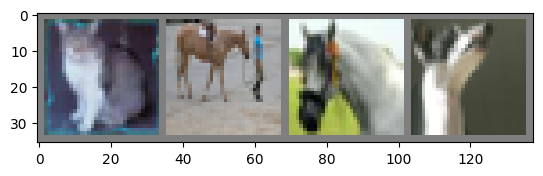

Epoch [1/5], Step [2000/12500], Loss: 2.2839
Epoch [1/5], Step [4000/12500], Loss: 2.3106
Epoch [1/5], Step [6000/12500], Loss: 2.2864
Epoch [1/5], Step [8000/12500], Loss: 2.2840
Epoch [1/5], Step [10000/12500], Loss: 2.2653
Epoch [1/5], Step [12000/12500], Loss: 2.1090
Epoch [2/5], Step [2000/12500], Loss: 2.0844
Epoch [2/5], Step [4000/12500], Loss: 1.8709
Epoch [2/5], Step [6000/12500], Loss: 1.6801
Epoch [2/5], Step [8000/12500], Loss: 1.4865
Epoch [2/5], Step [10000/12500], Loss: 1.3206
Epoch [2/5], Step [12000/12500], Loss: 1.4283
Epoch [3/5], Step [2000/12500], Loss: 2.0987
Epoch [3/5], Step [4000/12500], Loss: 1.7448
Epoch [3/5], Step [6000/12500], Loss: 1.9590
Epoch [3/5], Step [8000/12500], Loss: 1.0289
Epoch [3/5], Step [10000/12500], Loss: 1.7644
Epoch [3/5], Step [12000/12500], Loss: 1.1950
Epoch [4/5], Step [2000/12500], Loss: 1.5557
Epoch [4/5], Step [4000/12500], Loss: 1.4308
Epoch [4/5], Step [6000/12500], Loss: 1.1640
Epoch [4/5], Step [8000/12500], Loss: 1.4948
Epoc

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')